# Maps of Arctic sea ice thickness and MYI concentration 

In [16]:
%matplotlib inline
import sys
sys.path.append('../src')

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

import numpy as np
import datetime
import pandas as pd
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import brkup_utils.mask_funcs as msk
from brkup_utils import process_data
from brkup_utils.boxnames import *
import brkup_utils.lead_detect as ld
from brkup_utils.grid_funcs import *
from brkup_utils import plot_funcs


In [5]:
# setup directories
INDIR = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/'    
GRIDDIR = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-I/'

In [11]:
# read moorings 

months = ['01', '02', '03']
years = list(range(2000, 2018+1))
region=None

# subset Beaufort Sea and daily averaged moorings 
ds = process_data.load_moorings(INDIR,months,years,region=region,period=None)

# create masks
Mask = msk.Masking(ds, bbox=None)
msk_moore22 = Mask.get_Moore2022_Beaufort_mask()

months: ['01', '02', '03']
years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
DONE!


In [12]:
# winter mean values (JFM)

sic_JFM = ds['sic'].groupby('time.year').mean(dim='time')

#-- sea ice age
sia_JFM = ds['sia'].groupby('time.year').mean(dim='time')
sia_JFM = sia_JFM/(60*60*24*360)

# set all 0 values to nan
sia_JFM = sia_JFM.where(sia_JFM > 0)

#-- multiyear ice contour (0.4)
myi_conc_JFM = ds['conc_myi'].groupby('time.year').mean(dim='time')

#-- ice thickness
sit_JFM = ds['sit'].groupby('time.year').mean(dim='time')
sit_JFM = sit_JFM.where(sit_JFM > 0) # set all 0 values to nan

#-- mean thickness in the Beaufort Sea 
sit_JFMavg = sit_JFM.where(msk_moore22).mean(dim=('x', 'y'))

#-- mean MYI conc in the Beaufort Sea 
myi_conc_JFMavg = myi_conc_JFM.where(msk_moore22).mean(dim=('x', 'y'))

# sea ice drift
icespeed = ds['sea_ice_drift'].groupby('time.year').mean(dim='time')
icespeed = icespeed*100 # cm/s
icespeed.attrs['units'] = 'cm s-1'

## Mean ice thickness for 2000-2004 and 2014-2018
tmp1 = sit_JFMavg.sel(year=slice(2000, 2004)).mean('year').values
tmp2 = sit_JFMavg.sel(year=slice(2014, 2018)).mean('year').values
print(f'Average ice thickness Beaufort, 2000-2004: {tmp1}')
print(f'Average ice thickness Beaufort, 2014-2018: {tmp2}')

Average ice thickness Beaufort, 2000-2004: 1.8942028284072876
Average ice thickness Beaufort, 2014-2018: 1.627205491065979


In [13]:
# function for plotting gates
def plot_gates(ax, lonlat1, lonlat2, **kw):
    
    gate = ax.plot([lonlat1[0], lonlat2[0]], [lonlat1[1], lonlat2[1]], transform=ccrs.Geodetic(), **kw)
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    
    import matplotlib.colors as colors
    
    
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    
    return new_cmap

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


def add_colorbar(im):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    cax = inset_axes(ax,
                width="5%",  # width = 50% of parent_bbox width
                height="50%",  # height : 5%
                loc='center left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0)

    cbar = plt.colorbar(im, cax=cax, orientation="vertical", aspect=30, shrink=0.28)
    
    return cbar

In [14]:
def plot_ITD_histogram(ax, t1, t2, plotvar):

    units = plotvar.units
    labels = (f'{t1[0]}-{t1[1]}', f'{t2[0]}-{t2[1]}') 
    kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=60, ec="k")

    itd_t1 = plotvar.sel(year=slice(t1[0],t1[1])).where(msk_moore22).mean(axis=0)
    itd_t2 = plotvar.sel(year=slice(t2[0],t2[1])).where(msk_moore22).mean(axis=0)

    colors = ('C0', 'C1')

    itd_t1.plot.hist(ax=ax, **kwargs, label=labels[0])
    itd_t2.plot.hist(ax=ax, **kwargs, label=labels[1])
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    # Plot mean  
    t1_mean = np.round(itd_t1.mean().values,1)
    t2_mean = np.round(itd_t2.mean().values,1)

    t1_median=np.nanmedian(itd_t1)
    t2_median=np.nanmedian(itd_t2)

    print("median t1= {:.2f}".format(t1_median))
    print("median t2= {:.2f}".format(t2_median))

    ax.axvline(itd_t1.mean(), color=colors[0], linestyle='dashed', linewidth=1)
    ax.axvline(itd_t2.mean(), color=colors[1], linestyle='dashed', linewidth=1)

    label1 = "mean = {:.1f}".format(t1_mean)
    label2 = "mean = {:.1f}".format(t2_mean)

    ax.text(.60, .6, f'{label1} {units}', ha='left', va='top', transform=ax.transAxes, fontsize=10, color='C0')
    ax.text(.60, .5, f'{label2} {units}', ha='left', va='top', transform=ax.transAxes, fontsize=10, color='C1')

    #ax.set_xlabel('Sea ice thickness (m)')
    ax.set_ylabel('Density')

#dy = 0
#for var, color in zip((itd_t1, itd_t2), colors):
#    _mean = np.round(_mean.values,2)
#    print('average', _mean)
#    ax.text(.9, .2+dy, f'{_mean}', ha='left', va='top', transform=ax.transAxes, fontsize=12, color=color)
#    dy += 0.1


## Plot Figure 2


(603, 528, 3)
median t1= 6.60
median t2= 7.90


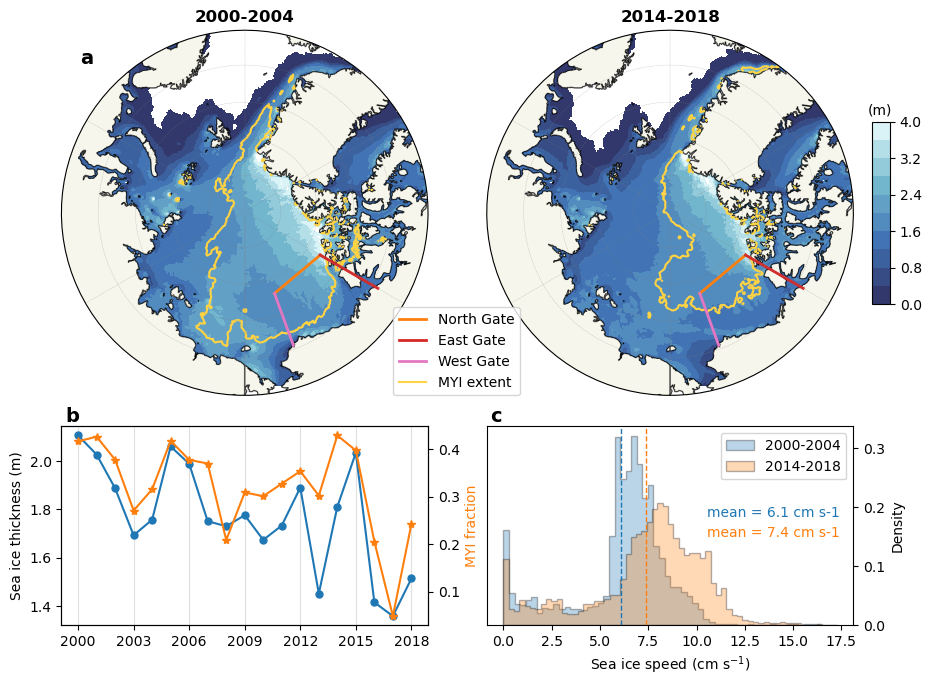

In [17]:
# prepare the plot

# get lon/lat from model
lon = ds['longitude'].values
lat = ds['latitude'].values

plot_crs = ccrs.NorthPolarStereo(central_longitude=-180, true_scale_latitude=60)

xy = plot_crs.transform_points(ccrs.PlateCarree(), lon, lat)
x = xy[:,:,0]
y = xy[:,:,1]
print(xy.shape)

sia_levs = np.arange(0,4+1, 1)

# multiyear ice conc threshold =0.4 (see Heather's paper). This provides the best fit to OSISAF Ice Type
myi_conc_lev = 0.4

cmap = cmocean.cm.ice
new_cmap = truncate_colormap(cmap, 0.2, 1, n=4)

kw_c = {'cmap': new_cmap,
        'zorder':0,
        'levels': np.arange(0,4.4, 0.4)
        #'vmin':0,
        #'vmax':5,
       }

kw_cl = {'colors': ['#ffd343'],
        }

t1 =  ('2000', '2004')
t2 =  ('2014', '2018')

# create figure
fig = plt.figure(figsize=(8,8),
                 #constrained_layout=True,
                 #tight_layout=True,
               )
gs = gridspec.GridSpec(3, 2, 
                       #width_ratios=[2, 2], height_ratios=[4, 1],
                       left=0.01, right=1, wspace=0.16, hspace=0.05,
                      )

ax1 = fig.add_subplot(gs[:-1, 0], projection= plot_crs,)
ax2 = fig.add_subplot(gs[:-1, 1], projection= plot_crs,)
ax3 = fig.add_subplot(gs[-1, 0])
ax4 = fig.add_subplot(gs[-1, 1])

#plt.subplots_adjust(bottom=0.02, top=0.98, left=0.02, right=0.95, wspace=0.01, hspace=0.02)
for t, ax  in zip([t1, t2], (ax1, ax2)):
    #ax = fig.add_subplot(gs[:-1, i], projection= plot_crs)
    
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1, alpha=0.5, facecolor=cfeature.COLORS['land'])
    ax.coastlines(lw=0.3)
    ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3, alpha=0.5, ls='--')
    ax.set_title(f'{t[0]}-{t[1]}', fontweight='bold')
    
    c = ax.contourf(x, y, sit_JFM.sel(year=slice(t[0],t[1])).mean(axis=0), transform=plot_crs, **kw_c )
#    c = ax.pcolormesh(x, y, sit_JFM.sel(time=slice(t[0],t[1])).mean('time'), transform=plot_crs, **kw_c )

    cl = ax.contour(x, y, myi_conc_JFM.sel(year=slice(t[0],t[1])).mean(axis=0), [myi_conc_lev], transform=plot_crs, **kw_cl)

    plot_funcs.polarCentral_set_latlim([65, 90], ax)
    
    # add gates
    north = plot_gates(ax, (-120, 78), (-160, 78.), color='tab:orange', lw=2, label='North Gate')  
    east = plot_gates(ax, (-120, 78), (-120, 69.), color='tab:red', lw=2, label='East Gate')
    west = plot_gates(ax, (-160, 78), (-160, 70.5), color='tab:pink', lw=2, label='West Gate')
    
### SUBPLOT 3
ax3.grid(axis='x', ls='-', alpha=0.4)
ax3.set_xticks(np.arange(2000,2019,3))                  
#sit_JFMavg.plot(ax=ax2) 

for i, var in enumerate([sit_JFMavg, myi_conc_JFMavg]):
    
    if i==0:
        col='tab:blue'
        var.plot(ax=ax3, marker='o', markersize=5, color=col)
        ax3.set_ylabel('Sea ice thickness (m)')
        #ax[0].axhline(y=var_JFM.mean('year'), linestyle='--', color = 'tab:blue', zorder=2)
        ax3.set_xlabel('')

    elif i==1:
        col='tab:orange'
        ax3r=ax3.twinx()
        var.plot(ax=ax3r, marker='*', markersize=6, color=col)      
        ax3r.set_ylabel('MYI fraction', color=col)

cb = add_colorbar(c)
cb.set_label('(m)', rotation=0, y=1.1, labelpad=-30)
#ax3r.legend(loc='lower left')

### SUBPLOT 4
plot_ITD_histogram(ax4, t1 ,t2, icespeed)
ax4.set_xlabel('Sea ice speed (cm s$^{-1}$)')
ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
ax4.set_yticks([0, 0.1, 0.2, 0.3])

# add figure labels
ax1.set_zorder(100)
ax1.text(0.05, 0.95, 'a', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top')    
ax3.text(0.01, 1.1, 'b', transform=ax3.transAxes,fontsize=14, fontweight='bold', va='top')
ax4.text(0.01, 1.1, 'c', transform=ax4.transAxes,fontsize=14, fontweight='bold', va='top')

# Add custom legend
yellow_line = mlines.Line2D([], [], color='#ffd343', label='MYI extent')
handles, labels = ax1.get_legend_handles_labels()

ax1_leg = ax1.legend(handles=handles + [yellow_line], bbox_to_anchor=(1.25, 0.), loc='lower right', borderaxespad=0.)
ax1_leg.set_zorder(100) 

plt.show()

labels = (f'{t1[0]}-{t1[1]}', f'{t2[0]}-{t2[1]}') 

fig.savefig('../figures/' + f'fig02_maps_arctic_iceThickness_MYIconc_icespeedHist_{labels[0]}_{labels[1]}.png', dpi=300, bbox_inches='tight')
#fig.savefig(FIGDIR + f'maps_arctic_iceThickness_MYIconc_ITDhist_{labels[0]}_{labels[1]}.png', dpi=300, bbox_inches='tight')
#fig.savefig(FIGDIR + 'maps_arctic_iceThickness_MYIconc_2000-2003_2016-2018_NoLabels.png', dpi=300, bbox_inches='tight')
